In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

In [3]:
# https://drive.google.com/file/d/1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0/view?usp=drive_link
!gdown 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0

Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=5ddb3119-a589-4b21-879b-c360ed20b2b3
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:06<00:00, 99.2MB/s]


In [4]:
!unzip -q /content/img_cls_weather_dataset.zip

In [5]:
root_dir = '/content/weather-dataset/dataset'
img_paths = []
labels = []
classes = {
    label_idx: class_name
    for label_idx, class_name in enumerate(
        sorted(os.listdir(root_dir))
    )
}

In [6]:
img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

In [7]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    shuffle=is_shuffle
)

In [8]:
class WeatherDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.img_paths = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [9]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img


In [10]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [11]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)

        return x


In [13]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride)
            blocks.append(block)

        block_sequential = nn.Sequential(* blocks)

        return block_sequential

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [14]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(ResidualBlock, [2, 2, 2, 2], n_classes).to(device)

In [15]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [16]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tValloss: {val_loss:.4f}')

    return train_losses, val_losses


In [17]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.8567	Valloss: 2.3899
EPOCH 2:	Train loss: 1.2617	Valloss: 2.4050
EPOCH 3:	Train loss: 0.9833	Valloss: 2.3239
EPOCH 4:	Train loss: 0.7980	Valloss: 1.7802
EPOCH 5:	Train loss: 0.6240	Valloss: 1.3112
EPOCH 6:	Train loss: 0.4963	Valloss: 1.0701
EPOCH 7:	Train loss: 0.4102	Valloss: 1.1633
EPOCH 8:	Train loss: 0.2892	Valloss: 1.0220
EPOCH 9:	Train loss: 0.2026	Valloss: 0.9760
EPOCH 10:	Train loss: 0.1589	Valloss: 1.0149
EPOCH 11:	Train loss: 0.1112	Valloss: 0.9656
EPOCH 12:	Train loss: 0.0883	Valloss: 0.9827
EPOCH 13:	Train loss: 0.0630	Valloss: 0.9494
EPOCH 14:	Train loss: 0.0575	Valloss: 0.9487
EPOCH 15:	Train loss: 0.0434	Valloss: 0.9429
EPOCH 16:	Train loss: 0.0423	Valloss: 1.0150
EPOCH 17:	Train loss: 0.0361	Valloss: 0.9513
EPOCH 18:	Train loss: 0.0289	Valloss: 0.9477
EPOCH 19:	Train loss: 0.0259	Valloss: 0.9440
EPOCH 20:	Train loss: 0.0222	Valloss: 0.9431
EPOCH 21:	Train loss: 0.0204	Valloss: 0.9572
EPOCH 22:	Train loss: 0.0173	Valloss: 0.9510
EPOCH 23:	Train los

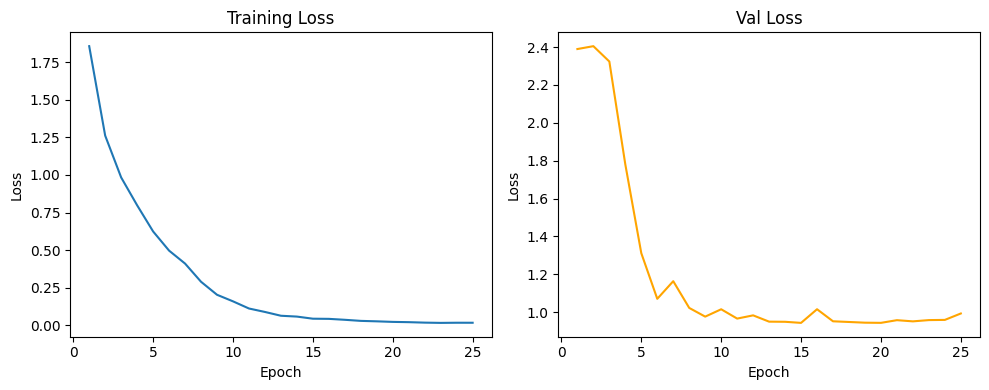

In [20]:
epochs_range = range(1, epochs + 1)

# Plotting Training and Validation Loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Training Loss
axes[0].plot(epochs_range, train_losses, color='tab:blue')
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Validation Loss
axes[1].plot(epochs_range, val_losses, color='orange')
axes[1].set_title("Val Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

In [21]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset ')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)


Evaluation on val/test dataset 
Val accuracy:  0.6919155134741443
Test accuracy:  0.6797671033478894
